In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
import numpy as np

### illustrate the how AdaBoost Classifier work

1. Create the dataset

2. initialize the sample weight 1/(number of rows in the data) 

In [2]:
data = pd.DataFrame({'Chest Pain': [1,0,0,1,0,1,0,1],
                    'Good Blood Circulation.':[1,0,0,1,0,1,0,1],
                    'Patient Weights':[205,180,210,167,156,125,168,172,],
                     'Heart Disease':[1,1,1,1,0,0,0,0]
                    })

# initially, all sample get the same weight
# weight = 1/number of sample
data['sample weight'] =1/8
data

,Chest Pain,Good Blood Circulation.,Patient Weights,Heart Disease,sample weight
0,1,1,205,1,0.125
1,0,0,180,1,0.125
2,0,0,210,1,0.125
3,1,1,167,1,0.125
4,0,0,156,0,0.125
5,1,1,125,0,0.125
6,0,0,168,0,0.125
7,1,1,172,0,0.125


### Use the patient weights to detect heart disease

1. since it is best variable to separate the heart disease

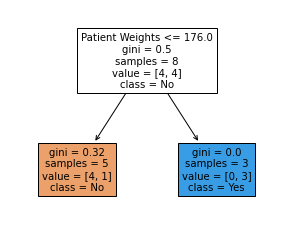

In [3]:
X,y = data[['Patient Weights']], data['Heart Disease'] 
tree1 = DecisionTreeClassifier(max_depth=1)
tree1 = tree1.fit(X, y)

fig = plt.figure(figsize=(5,4))
_ = tree.plot_tree(tree1, feature_names = X.columns, class_names = ['No', 'Yes'], filled = True)

### Since the first prediction is made, 

1. we need to update the sample weight

2. we firstly need to calculate the total error

3. then calculate the amount of say

\begin{equation*}
Amount \, of \, Say   = \frac{1}{2} \times log(\frac{1-Total \, error}{Total \, error})
\end{equation*}

In [4]:

total_error = sum((y - tree1.predict(data[['Patient Weights']])) * data['sample weight'])
print('We made a prediction error. \nThen total error is the total number of misclassification multiply the sample weight')
print('Total error is 1/8')
amount_of_say = 1/2*np.log((1-total_error)/total_error)
print('Using the formula mention above, Amount of Say is',amount_of_say)


We made a prediction error. 
Then total error is the total number of misclassification multiply the sample weight
Total error is 1/8
Using the formula mention above, Amount of Say is 0.9729550745276566


### We need to assign new sample weight

**For the misclassified rows**

\begin{equation*}
New \, Sample \, Weight  = Old \, Sample \, Weight \times e^{amount of say}
\end{equation*}

**For the correctly predicted rows**

\begin{equation*}
New \, Sample \, Weight  = Old \, Sample \, Weight \times e^{-amount of say}
\end{equation*}

In [5]:
new_weight = [np.exp(amount_of_say)*data['sample weight'][idx] 
                  if val != y[idx]  else np.exp(-1*amount_of_say)*data['sample weight'][idx]  
              for idx,val in enumerate(tree1.predict(data[['Patient Weights']])) ]


In [6]:
data['new_weight'] = new_weight/sum(new_weight)
data

,Chest Pain,Good Blood Circulation.,Patient Weights,Heart Disease,sample weight,new_weight
0,1,1,205,1,0.125,0.071429
1,0,0,180,1,0.125,0.071429
2,0,0,210,1,0.125,0.071429
3,1,1,167,1,0.125,0.500000
4,0,0,156,0,0.125,0.071429
5,1,1,125,0,0.125,0.071429
6,0,0,168,0,0.125,0.071429
7,1,1,172,0,0.125,0.071429


In [7]:
cols = ['Chest Pain', 'Good Blood Circulation.', 
        'Patient Weights','Heart Disease']

from numpy.random import choice

temp2 = data[cols].loc[choice(range(8), 8,p=data['new_weight'])]

temp2['sample weight'] =1/8

# We can observe that 3rd index row shows up many times
# We want to correct the mistake we made last time
# by giving that row more weight
temp2

,Chest Pain,Good Blood Circulation.,Patient Weights,Heart Disease,sample weight
1,0,0,180,1,0.125
6,0,0,168,0,0.125
2,0,0,210,1,0.125
3,1,1,167,1,0.125
3,1,1,167,1,0.125
3,1,1,167,1,0.125
3,1,1,167,1,0.125
3,1,1,167,1,0.125


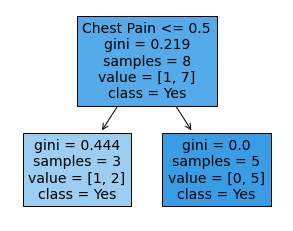

In [8]:
## Since we are making a point
# let us not use patient weights again, because we can't calculate the amount of say if we 
# use patient weights again
#


X,y = temp2[list(set(cols)-{'Patient Weights','Heart Disease'})], temp2['Heart Disease'] 
tree2 = DecisionTreeClassifier(max_depth=1)
tree2 = tree2.fit(X, y)

fig = plt.figure(figsize=(5,4))
_ = tree.plot_tree(tree2, feature_names = temp2.columns, class_names = ['No', 'Yes'], filled = True)

### Since we made another tree, we use above-mentioned methods to calculate the amount of say

**Repeat previous steps until the number of iterations equals the number specified by the hyperparameter (i.e. number of estimators)**

In [9]:

total_error = sum(abs(y - tree2.predict(temp2[list(set(cols)-{'Patient Weights','Heart Disease'})])) 
                  * list(temp2['sample weight']))
amount_of_say = 1/2*np.log((1-total_error)/total_error)
amount_of_say

0.9729550745276566

**The AdaBoost model makes predictions by having each tree in the forest classify the sample. Then, we split the trees into groups according to their decisions. For each group, we add up the significance of every tree inside the group. The final classification made by the forest as a whole is determined by the group with the largest sum.**


In [10]:
pd.DataFrame({'Trees predict positive': [1,2,3,4],
                    'Total amount of say(positive class).':[0.25]*4,
                    'Trees predict negative':[5,6,7, 8],
                     'Total amount of say(negative class)':[0.5]*4
                    })

# Since the amount of say of the negative class is higher

## Therefore, it will predict negative

,Trees predict positive,Total amount of say(positive class).,Trees predict negative,Total amount of say(negative class)
0,1,0.25,5,0.5
1,2,0.25,6,0.5
2,3,0.25,7,0.5
3,4,0.25,8,0.5
